In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.ndimage import gaussian_filter
from PIL import Image

%matplotlib inline

random = np.random.default_rng()

# Using the dataset in a simple autoencoder

In [25]:
class NumpyArrayDataset(Dataset):
    def __init__(self, path):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
        noisy_image = 100 * np.reshape(entry[0], (1, *self.img_shape))
        true_image  = 100 * np.reshape(entry[1], (1, *self.img_shape))
    
        # entry[0] is the noisy image, entry[1] is the true image. The
        # goal will be for the network to learn the mapping
        # noisy --> true.
        return (noisy_image.astype(np.single), true_image.astype(np.single))
    
    def __len__(self):
        return len(self.npzfile)

In [26]:
path = "shapes-dataset.npz"

# Load the shapes dataset as a PyTorch Dataset
shapes_dataset = NumpyArrayDataset(path)

# Split into test and training set
n = len(shapes_dataset)
train_size = 4 * n // 5
test_size = n - train_size

train_data, test_data = random_split(shapes_dataset, 
                                     [train_size, test_size])

# Construct the DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=4)
test_loader  = DataLoader(test_data,  batch_size=4)

## Verifying all the dimensions

In [27]:
# The dimensions of an element of the train loader are:
# (batch size, channels, image width, image height)
thing = next(iter(train_loader))
print(type(thing))
print(len(thing))
print(type(thing[0]))
print(type(thing[1]))
print(thing[0].shape)
print(thing[1].shape)

<class 'list'>
2
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        #Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.t_conv1(x))
        x = self.sigmoid(self.t_conv2(x))
              
        return x

model = ConvAutoencoder().to(device)
    
# model = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
# #     nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
# #     nn.Linear(120, 84), nn.Sigmoid(),
# #     nn.Linear(84, 10)
# ).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [35]:
epochs = 100

for epoch in range(epochs):
    loss = 0
    for batch_true, batch_noisy in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_noisy = batch_noisy.to(device)
        batch_true = batch_true.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_noisy.float())
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_true)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    if epoch % 5 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/100, loss = 0.000492
epoch : 6/100, loss = 0.000484
epoch : 11/100, loss = 0.000478
epoch : 16/100, loss = 0.000473
epoch : 21/100, loss = 0.000469
epoch : 26/100, loss = 0.000466
epoch : 31/100, loss = 0.000463
epoch : 36/100, loss = 0.000460
epoch : 41/100, loss = 0.000458
epoch : 46/100, loss = 0.000456
epoch : 51/100, loss = 0.000454
epoch : 56/100, loss = 0.000452
epoch : 61/100, loss = 0.000450
epoch : 66/100, loss = 0.000449
epoch : 71/100, loss = 0.000447
epoch : 76/100, loss = 0.000446
epoch : 81/100, loss = 0.000444
epoch : 86/100, loss = 0.000443
epoch : 91/100, loss = 0.000442
epoch : 96/100, loss = 0.000441


## Visualise the results of the network

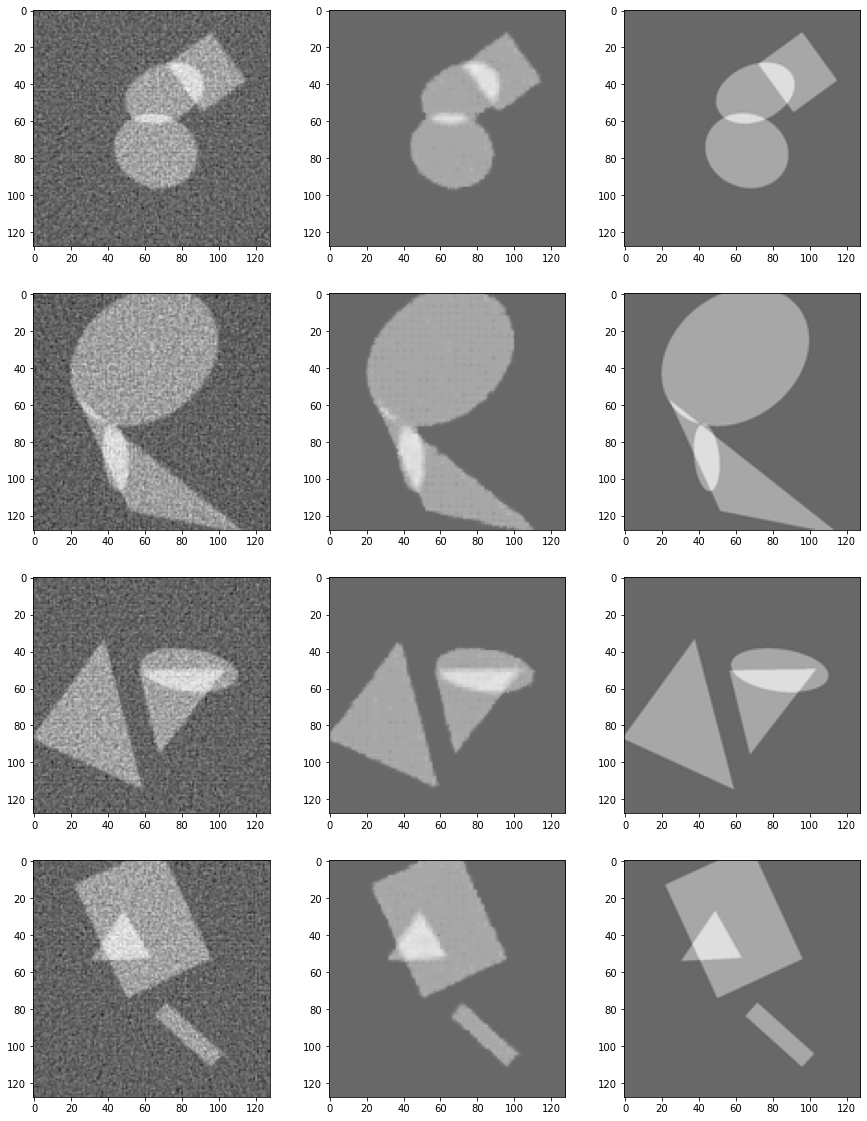

In [36]:
def show_batches(*args):
    """It is assumed that all tensors contain an equal number of
    images."""
    batch_tensors = args
    
    # Assert that we are working with a grayscale iamge
    assert all(tensor.shape[1] == 1 for tensor in batch_tensors)
    
    num_batches = len(batch_tensors)
    num_images = batch_tensors[0].shape[0]
    
    fig, axs = plt.subplots(num_images, num_batches, 
                            figsize=(5 * num_batches, 5 * num_images))
    
    for i in range(num_images):
        for j in range(num_batches):
            axs[i, j].imshow(batch_tensors[j][i, 0], vmin=-0.5, vmax=1, cmap=plt.cm.Greys_r)

with torch.no_grad():
    for batch_true, batch_noisy in test_loader:
        model_output = model(batch_noisy.to(device))
        show_batches(batch_noisy, model_output.cpu(), batch_true)
        break

## Save the trained model to a file

In [39]:
torch.save(model.state_dict(), 'trained-model.pth')

In [42]:
other_model = ConvAutoencoder()
other_model.load_state_dict(torch.load('trained-model.pth'))

<All keys matched successfully>

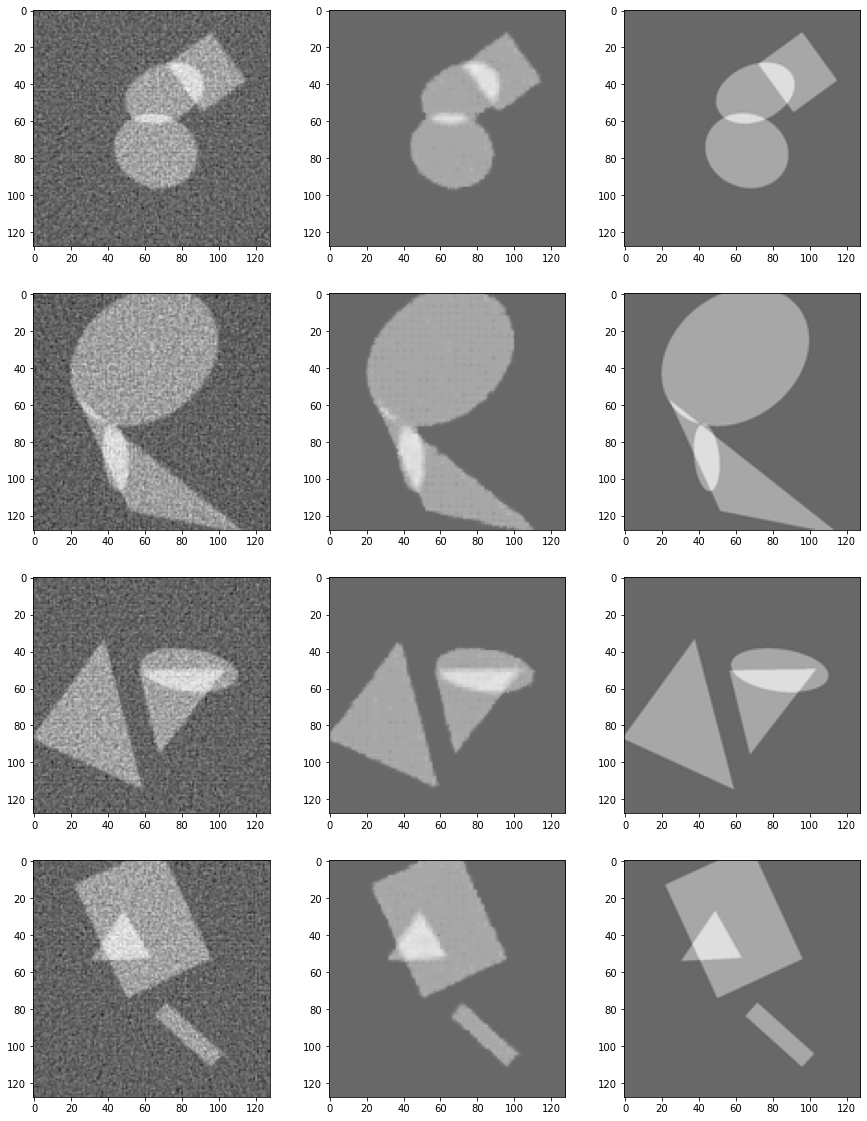

In [44]:
other_model.to(device)

with torch.no_grad():
    for batch_true, batch_noisy in test_loader:
        model_output = other_model(batch_noisy.to(device))
        show_batches(batch_noisy, model_output.cpu(), batch_true)
        break